In [102]:
install.packages(c("glmmTMB","performance","effects", "ggplot2", "dplyr", "patchwork"))

trying URL 'https://cran.rstudio.com/bin/macosx/big-sur-arm64/contrib/4.5/glmmTMB_1.1.13.tgz'
trying URL 'https://cran.rstudio.com/bin/macosx/big-sur-arm64/contrib/4.5/performance_0.15.2.tgz'
trying URL 'https://cran.rstudio.com/bin/macosx/big-sur-arm64/contrib/4.5/effects_4.2-4.tgz'
trying URL 'https://cran.rstudio.com/bin/macosx/big-sur-arm64/contrib/4.5/ggplot2_4.0.1.tgz'
trying URL 'https://cran.rstudio.com/bin/macosx/big-sur-arm64/contrib/4.5/dplyr_1.1.4.tgz'
trying URL 'https://cran.rstudio.com/bin/macosx/big-sur-arm64/contrib/4.5/patchwork_1.3.2.tgz'



The downloaded binary packages are in
	/var/folders/gk/8lmvml_s21x_1pb8gf75j8bh0000gn/T//RtmpHk4j1h/downloaded_packages


In [103]:
# PACKAGES
library(glmmTMB)
library(effects)
library(performance)
library(ggplot2)
library(dplyr)
library(patchwork)

In [ ]:
dat <- read.csv("exam2023_data-2.csv", stringsAsFactors = FALSE)

# 1. Minimal preprocessing
dat$Property <- factor(dat$Property)
dat$Season <- factor(dat$Season)
dat$Aspect <- factor(dat$Aspect)
dat$Landscape.position <- factor(dat$Landscape.position)

# Response: total seedlings (sum across height classes)
dat$EucalyptSeedlings <- rowSums(dat[, c(
  "euc_sdlgs0_50cm", 
  "euc_sdlgs50cm.2m", 
  "euc_sdlgs.2m")], na.rm = TRUE)


# Sum grass covers
dat$Grass_cover <- rowSums(dat[, c("ExoticAnnualGrass_cover",
                                    "NativePerennialGrass_cover",
                                    "ExoticPerennialGrass_cover")], na.rm = TRUE)

# Sum herb covers
dat$Herb_cover <- rowSums(dat[, c("ExoticAnnualHerb_cover",
                                  "ExoticPerennialHerb_cover",
                                  "NativePerennialHerb_cover")], na.rm = TRUE)

# Sum shrub covers
dat$Shrub_cover <- rowSums(dat[, c("ExoticShrub_cover",
                                    "NativeShrub_cover")], na.rm = TRUE)

dat$Fern_cover <- dat$NativePerennialFern_cover

# Sum non-plant covers if you want
dat$NonPlant_cover <- rowSums(dat[, c("BareGround_cover", "Litter_cover",
                                      "MossLichen_cover", "Rock_cover")], na.rm = TRUE)

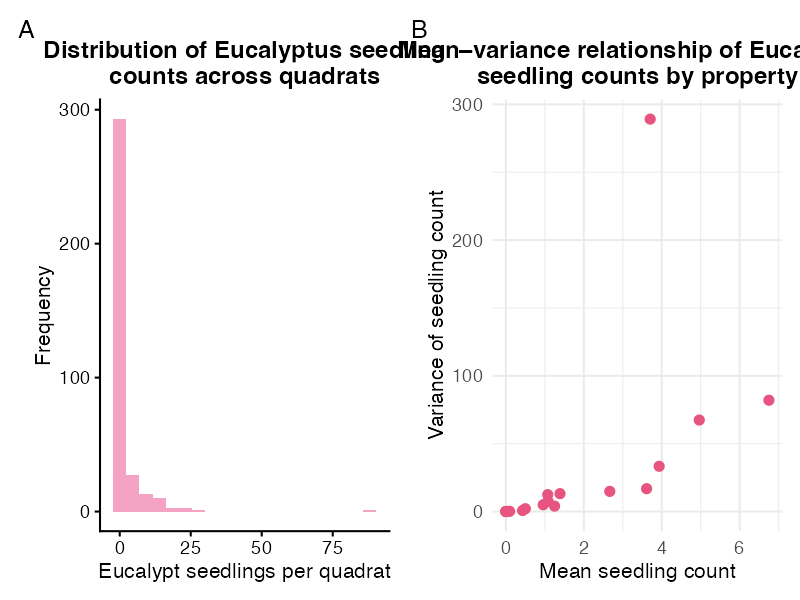

In [ ]:
# Figure 1
p1 <- ggplot(dat_z, aes(x = EucalyptSeedlings)) +
  geom_histogram(
    bins = 20,
    fill = "#F4A3C4"
  ) +
  labs(
    title = "Distribution of Eucalyptus seedling\ncounts across quadrats",
    x = "Eucalypt seedlings per quadrat",
    y = "Frequency"
  ) +
  theme_classic(base_size = 16) +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5, size = 18),
    axis.title = element_text(size = 16),
    axis.text  = element_text(size = 14)
  )

p2 <- ggplot(mean_var, aes(x = mean_count, y = var_count)) +
  geom_point(size = 3, colour = "#E75480") +
  labs(
    title = "Mean–variance relationship of Eucalyptus\nseedling counts by property",
    x = "Mean seedling count",
    y = "Variance of seedling count"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5, size = 18),
    axis.title = element_text(size = 16),
    axis.text  = element_text(size = 14)
  )

figure <- (p1 | p2) +             
  plot_annotation(tag_levels = "A")

figure

ggsave("seedlings_panel.png", figure, width = 14, height = 6, dpi = 300)

In [107]:
# 2. Select initial candidate predictors (selected for biological plausibility)
cand_vars <- c(
  "Euc_canopy_cover",
  "Distance_to_Eucalypt_canopy.m.",
  "Grass_cover",
  "Herb_cover",
  "Shrub_cover",
  "Fern_cover",
  "NonPlant_cover",
  "annual_precipitation",
  "SRad_Jan",
  "SRad_Jul",
  "MrVBF",
  "Landscape.position",
  "Aspect",
  "Season"
)

In [108]:
# checking the number of na values for each predictor
sapply(dat[, cand_vars], function(x) sum(is.na(x)))

              Euc_canopy_cover Distance_to_Eucalypt_canopy.m.                    Grass_cover                     Herb_cover 
                             1                              2                              0                              0 
                   Shrub_cover                     Fern_cover                 NonPlant_cover           annual_precipitation 
                             0                              1                              0                              2 
                      SRad_Jan                       SRad_Jul                          MrVBF             Landscape.position 
                             2                              2                              2                              0 
                        Aspect                         Season 
                             0                              0 

In [ ]:
# fill in null values with mean
for (var in cand_vars) {
  if (any(is.na(dat[[var]]))) {
    dat[[var]][is.na(dat[[var]])] <- mean(dat[[var]], na.rm = TRUE)
  }
}

# 5. center & scale for model stability
cont_vars <- setdiff(cand_vars, c("Landscape.position","Aspect","Season"))
dat[cont_vars] <- lapply(dat[cont_vars], scale)

# 6. Final dataset ready for modeling
dat_z <- dat

In [110]:
global_formula <- as.formula(
  paste("EucalyptSeedlings ~", paste(c(cand_vars), collapse = " + "),
        "+ (1 | Property)")
)

# Fit global model with negative binomial
m_global <- glmmTMB(global_formula, family = nbinom1(), data = dat_z)
summary(m_global)

 Family: nbinom1  ( log )
Formula:          EucalyptSeedlings ~ Euc_canopy_cover + Distance_to_Eucalypt_canopy.m. +  
    Grass_cover + Herb_cover + Shrub_cover + Fern_cover + NonPlant_cover +  
    annual_precipitation + SRad_Jan + SRad_Jul + MrVBF + Landscape.position +      Aspect + Season + (1 | Property)
Data: dat_z

      AIC       BIC    logLik -2*log(L)  df.resid 
    879.5     987.6    -411.7     823.5       323 

Random effects:

Conditional model:
 Groups   Name        Variance Std.Dev.
 Property (Intercept) 1.342    1.158   
Number of obs: 351, groups:  Property, 18

Dispersion parameter for nbinom1 family (): 11.8 

Conditional model:
                                 Estimate Std. Error z value Pr(>|z|)  
(Intercept)                      -1.44097    1.06481  -1.353   0.1760  
Euc_canopy_cover                 -0.09056    0.11888  -0.762   0.4462  
Distance_to_Eucalypt_canopy.m.   -0.42524    0.17979  -2.365   0.0180 *
Grass_cover                       0.14127    0.23178   0

In [111]:
vif_tab <- check_collinearity(m_global)
vif_tab

# Check for Multicollinearity

Low Correlation

                           Term  VIF           VIF 95% CI adj. VIF Tolerance Tolerance 95% CI
               Euc_canopy_cover 1.46 [    1.31,     1.69]     1.21      0.68     [0.59, 0.76]
 Distance_to_Eucalypt_canopy.m. 1.39 [    1.26,     1.61]     1.18      0.72     [0.62, 0.80]
                    Grass_cover 4.25 [    3.61,     5.06]     2.06      0.24     [0.20, 0.28]
                     Herb_cover 1.78 [    1.57,     2.06]     1.33      0.56     [0.48, 0.64]
                    Shrub_cover 1.12 [    1.04,     1.32]     1.06      0.89     [0.76, 0.96]
                     Fern_cover 1.31 [    1.18,     1.51]     1.14      0.77     [0.66, 0.84]
                 NonPlant_cover 4.55 [    3.85,     5.41]     2.13      0.22     [0.18, 0.26]
           annual_precipitation 1.61 [    1.43,     1.86]     1.27      0.62     [0.54, 0.70]
                       SRad_Jan 1.82 [    1.60,     2.12]     1.35      0.55     [0.47, 0.62]
            

In [112]:
high_vif <- vif_tab$Term[vif_tab$VIF > 10]
high_vif

[1] "Landscape.position" "Aspect"            

In [113]:
cand_vars_clean <- setdiff(cand_vars, high_vif)
global_formula_clean <- as.formula(
  paste("EucalyptSeedlings ~", paste(c(cand_vars_clean, "Season"), collapse = " + "),
        "+ (1 | Property)")
)

m_clean <- glmmTMB(global_formula_clean, family = nbinom1(), data = dat_z)
summary(m_clean)

 Family: nbinom1  ( log )
Formula:          EucalyptSeedlings ~ Euc_canopy_cover + Distance_to_Eucalypt_canopy.m. +  
    Grass_cover + Herb_cover + Shrub_cover + Fern_cover + NonPlant_cover +      annual_precipitation + SRad_Jan + SRad_Jul + MrVBF + Season +  
    Season + (1 | Property)
Data: dat_z

      AIC       BIC    logLik -2*log(L)  df.resid 
    874.8     936.5    -421.4     842.8       335 

Random effects:

Conditional model:
 Groups   Name        Variance Std.Dev.
 Property (Intercept) 1.145    1.07    
Number of obs: 351, groups:  Property, 18

Dispersion parameter for nbinom1 family (): 13.5 

Conditional model:
                               Estimate Std. Error z value Pr(>|z|)  
(Intercept)                    -0.01055    0.37142  -0.028    0.977  
Euc_canopy_cover               -0.07084    0.10673  -0.664    0.507  
Distance_to_Eucalypt_canopy.m. -0.39434    0.16949  -2.327    0.020 *
Grass_cover                     0.10533    0.23105   0.456    0.648  
Herb_cover     

In [ ]:
# Testing different models with AIC

m0 <- glmmTMB(EucalyptSeedlings ~ 1 + (1 | Property/Quadrat.no),
              family = nbinom1(), data = dat_z)

m_canopydist <- glmmTMB(EucalyptSeedlings ~ Distance_to_Eucalypt_canopy.m. +
                    (1 | Property/Quadrat.no), family = nbinom1(), data = dat_z)

m_canopydist_moss <- glmmTMB(EucalyptSeedlings ~ Distance_to_Eucalypt_canopy.m. + MossLichen_cover + Herb_cover +
                    (1 | Property/Quadrat.no), family = nbinom1(), data = dat_z)

m_ground <- glmmTMB(EucalyptSeedlings ~ Herb_cover +
                    (1 | Property/Quadrat.no), family = nbinom1(), data = dat_z)

m_dist_herb <- glmmTMB(EucalyptSeedlings ~ Distance_to_Eucalypt_canopy.m. + 
                           Herb_cover +
                           (1 | Property/Quadrat.no), family = nbinom1(), data = dat_z)


m_dist_herb_nonplant <- glmmTMB(EucalyptSeedlings ~ Distance_to_Eucalypt_canopy.m. + 
                           Herb_cover + Grass_cover + Shrub_cover + Fern_cover + NonPlant_cover +
                           (1 | Property/Quadrat.no), family = nbinom1(), data = dat_z)

m_canopy_ground_climate <- glmmTMB(EucalyptSeedlings ~ Distance_to_Eucalypt_canopy.m. + 
                                  + Herb_cover +
                                   annual_precipitation +
                                   (1 | Property/Quadrat.no), family = nbinom1(), data = dat_z)

AICtab <- AIC(m0, m_canopydist, m_canopydist_moss, m_ground, m_dist_herb, m_dist_herb_nonplant, m_canopy_ground_climate, m_clean)
AICtab <- AICtab[order(AICtab$AIC), ]
AICtab

Warning message:
In AIC.default(m0, m_canopydist, m_canopydist_moss, m_ground, m_dist_herb,  :
  models are not all fitted to the same number of observations


                        df      AIC
m_canopydist_moss        7 855.5724
m_dist_herb              6 862.9401
m_canopydist             5 864.5800
m_canopy_ground_climate  7 864.8409
m_ground                 5 867.5962
m_dist_herb_nonplant    10 868.4765
m0                       4 872.9763
m_clean                 16 874.7502

In [ ]:
# summary of best model 
summary(m_canopy_moss)

 Family: nbinom1  ( log )
Formula:          EucalyptSeedlings ~ Distance_to_Eucalypt_canopy.m. + MossLichen_cover +      Herb_cover + (1 | Property/Quadrat.no)
Data: dat_z

      AIC       BIC    logLik -2*log(L)  df.resid 
    855.6     882.6    -420.8     841.6       343 

Random effects:

Conditional model:
 Groups              Name        Variance  Std.Dev. 
 Quadrat.no:Property (Intercept) 4.629e-08 0.0002152
 Property            (Intercept) 1.147e+00 1.0707754
Number of obs: 350, groups:  Quadrat.no:Property, 117; Property, 18

Dispersion parameter for nbinom1 family (): 13.4 

Conditional model:
                                Estimate Std. Error z value Pr(>|z|)   
(Intercept)                    -0.305633   0.350536  -0.872  0.38326   
Distance_to_Eucalypt_canopy.m. -0.349844   0.153979  -2.272  0.02308 * 
MossLichen_cover                0.018360   0.005686   3.229  0.00124 **
Herb_cover                     -0.355571   0.204995  -1.735  0.08282 . 
---
Signif. codes:  0 ‘***’ 0.